In [1]:
import sys
sys.path.append('../../')

In [2]:
# import this to use Intel optimized sklearn if available
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error, balanced_accuracy_score
from rdkit import Chem
from rdkit.Chem import Draw

from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def do_random_grid_extratrees():
    random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 2, stop = 150, num = 4)],
                   'max_depth': [int(x) for x in np.linspace(1, 10, num = 4)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False]}
                   #'class_weight': ['balanced_subsample','balanced'],
                   #'max_features': ['auto', 'sqrt'],}
    return random_grid

def do_random_grid_rf():
    # define parameters for gridsearchcv
    param_grid = {
        'bootstrap': [False],
        'max_depth': [5, 50, 100],
        'max_features': [3, 5],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [5, 10],
        'n_estimators': [5, 50, 100]
    }
    return param_grid

def do_random_grid_pls():
    n_components = [int(x) for x in np.linspace(start = 2, stop = 50, num = 6)]
    random_grid = {'n_components': n_components}
    return random_grid

def do_model(target, xtrain,ytrain, xtest, ytest, model, grid):
    #model = ExtraTreesRegressor(random_state=0)
    if grid:
        cross_val = KFold(n_splits=5)
        mod_random = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = 5, 
                                       cv = cross_val, verbose=0, random_state=64, n_jobs = -1)
        mod_random.fit(xtrain,ytrain)
        base_model = mod_random.best_estimator_

    else:
        base_model = model
        base_model.fit(xtrain,ytrain)
    pred = base_model.predict(xtest)
    score_tst = base_model.score(xtest,ytest)
    score_tr = base_model.score(xtrain,ytrain)

    return base_model, score_tst, score_tr

In [4]:
import os
path_to_figure_folder = os.path.join(os.getcwd(), 'figures/predictions_on_unseen_substrate')
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 8


# Objective 4: Predictions within a substrate class, but iteratively a smaller subset of ligands is selected so we can see the effect on the performance of the model

This case is mainly focused on regression models, since we wanted to investigate the bad performance

## Example application of pipeline

In [17]:
lig_descr = 'dft_nbd_model'
target ='DDG'

model = ExtraTreesRegressor(random_state=42)
grid = do_random_grid_extratrees()
#grid = do_random_grid_extratrees()
sub = 'SM1'
excluded_frac = 0.9
seed = 44710

ligand_numbers_column = 'Ligand#'
substrate_names_column = 'Substrate'

In [11]:
data = pd.read_csv('../data/experimental_response/jnjdata_sm12378_MeOH_16h.csv', sep = ';')
data

,Substrate,Ligand#,Temperature/C,Hydrogen/bar,Conversion,Eesign,EE,DDG,DConversion
0,SM1,L1,25,5,1.0,0.36,0.36,1.86,0.000
1,SM1,L2,25,5,1.0,0.00,0.00,0.02,0.000
2,SM1,L3,25,5,1.0,0.62,0.62,3.62,0.000
3,SM1,L4,25,5,1.0,0.18,0.18,0.89,0.439
4,SM1,L5,25,5,1.0,0.05,0.05,0.27,0.730
...,...,...,...,...,...,...,...,...,...
955,SM8,L188,50,5,1.0,-0.15,0.15,0.84,NaN
956,SM8,L189,50,5,1.0,-0.48,0.48,2.79,NaN
957,SM8,L190,50,5,1.0,-0.04,0.04,0.21,NaN
958,SM8,L191,50,5,1.0,-0.45,0.45,2.61,NaN


In [12]:
AVAILABLE_LIGAND_REPRESENTATION_TYPES = ['dft_nbd_model','dft_nbd_model_with_solvation', 'dl_chylon', 'ecfp', 'sigmangroup']

if lig_descr in lig_descr in AVAILABLE_LIGAND_REPRESENTATION_TYPES[2:]:
    lig_descr_df = pd.read_csv(f'../data/ligand_representations/ligands_{lig_descr}.csv', sep = ',|;', engine = 'python')            

else:
    lig_descr_df = pd.read_csv(f'../data/ligand_representations/ligands_{lig_descr}.csv', 
                               sep = ';')
lig_descr_df = lig_descr_df.dropna(axis = 0)

data_sub = data[(data[substrate_names_column]==sub)&(data[ligand_numbers_column].isin(lig_descr_df[ligand_numbers_column].values))]
data_sub = data_sub.drop([substrate_names_column,'Temperature/C','Hydrogen/bar','Conversion','Eesign','EE','DConversion'], axis = 1)
data_sub = data_sub.merge(lig_descr_df, on=ligand_numbers_column)

In [13]:
data_sub

,Ligand#,DDG,distance_pi_bond_1,distance_pi_bond_2,dihedral_angle_1,dihedral_angle_2,NE_quad,NW_quad,SW_quad,SE_quad,...,min_oct,max_oct,ratio_std_oct_std_quad,ratio_min_oct_min_quad,lone_pair_occ_min,lone_pair_occ_max,bite_angle_sin,bite_angle_cos,cone_angle_sin,cone_angle_cos
0,L1,1.86,1.390741,1.392787,7.686361,7.480901,0.507384,0.547917,0.504659,0.461866,...,0.080227,0.975727,11.989549,0.173703,1.11654,1.14908,0.999987,-0.005157,-0.968989,0.247103
1,L3,3.62,1.392435,1.388875,-14.645697,-6.935352,0.564806,0.563082,0.558610,0.535641,...,0.152907,0.973258,28.497842,0.285466,1.14418,1.15748,-0.601796,0.798650,-0.776797,-0.629751
2,L4,0.89,1.393590,1.386473,-0.287527,-4.731149,0.435427,0.483111,0.528233,0.558493,...,0.098444,0.958023,7.290780,0.226086,1.12136,1.14973,0.558299,-0.829640,0.913634,0.406539
3,L5,0.27,1.388324,1.388814,14.221076,-6.401581,0.528257,0.500489,0.488143,0.525508,...,0.056513,0.968459,21.615541,0.115772,1.09922,1.12834,-0.443164,0.896441,-0.076184,-0.997094
4,L6,6.54,1.386473,1.390094,-6.496966,-0.710323,0.568673,0.564946,0.554766,0.535455,...,0.131476,0.978056,28.230237,0.245541,1.13108,1.13978,-0.580062,-0.814572,0.737067,-0.675819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,L188,2.96,1.388426,1.388986,13.052655,3.147347,0.515584,0.499441,0.509085,0.576034,...,0.089266,0.973164,11.493865,0.178731,1.09947,1.15261,0.952392,-0.304877,0.715333,0.698784
183,L189,0.84,1.389425,1.392072,-2.926005,-15.168476,0.541395,0.530050,0.562220,0.473258,...,0.115263,0.967527,10.325740,0.243552,1.12884,1.14274,0.958485,0.285143,-0.994811,-0.101740
184,L190,1.60,1.389933,1.416352,45.517220,30.005971,0.540882,0.556769,0.524553,0.738446,...,0.234020,0.953271,3.092763,0.446132,1.19815,1.28155,-0.149314,-0.988790,0.861053,0.508515
185,L191,0.31,1.396287,1.408126,-18.184793,-2.615758,0.551971,0.560054,0.438199,0.518915,...,0.116148,0.970089,7.303975,0.265058,1.14992,1.16924,0.009058,0.999959,0.880022,0.474932


In [19]:
X_train, X_excluded = train_test_split(data_sub, test_size=excluded_frac, random_state=seed)

x_train, x_test, y_train, y_test = train_test_split(X_train.iloc[:,2:].values, X_train[target].values, test_size=0.33, random_state=42)
base_model, score_tst, score_tr = do_model(target, x_train,y_train, x_test,y_test, model, grid)

print(f'descr = {lig_descr}, model = {str(model)}, SM = {sub}, target = {target}, frac = {frac}, seed = {seed}, len_train = {len(y_train)}, len_test = {len(y_test)}, R2 train = {score_tr}, R2 test ={score_tst}')

descr = dft_nbd_model, model = ExtraTreesRegressor(random_state=42), SM = SM1, target = DDG, frac = 0.9, seed = 44710, len_train = 12, len_test = 6, R2 train = 0.9813720613854064, R2 test =0.7912544058823303


In [21]:
from sklearn.inspection import permutation_importance
import time
feature_names = list(X_train.columns[2:])
start_time = time.time()
result = permutation_importance(
    base_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 5.930 seconds


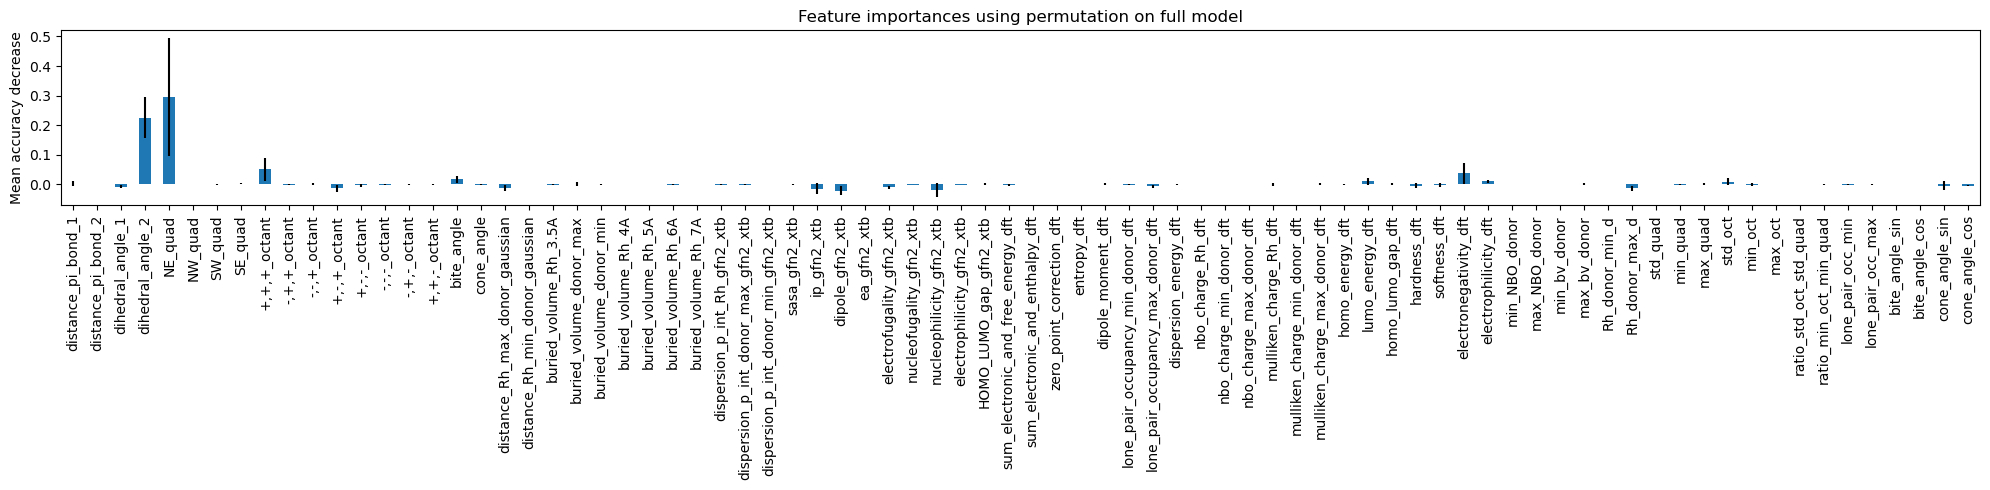

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [23]:
pred_train = base_model.predict(x_train)
pred_test = base_model.predict(x_test)

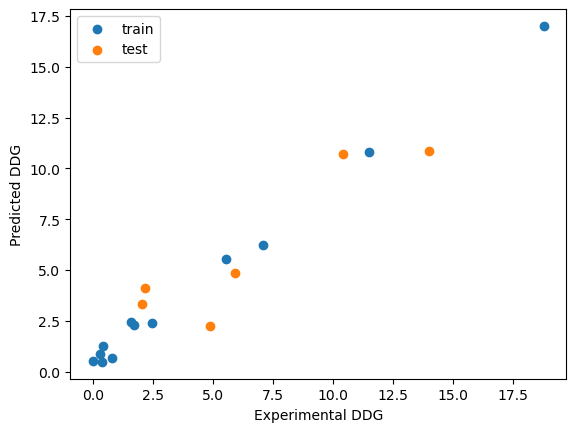

In [24]:
plt.scatter(y_train, pred_train)
plt.scatter(y_test, pred_test)
plt.ylabel('Predicted DDG')
plt.xlabel('Experimental DDG')
plt.legend(['train','test'])

In [25]:
x_train, x_test = train_test_split(X_train, test_size=0.33, random_state=42)

In [26]:
x_train

,Ligand#,DDG,distance_pi_bond_1,distance_pi_bond_2,dihedral_angle_1,dihedral_angle_2,NE_quad,NW_quad,SW_quad,SE_quad,...,min_oct,max_oct,ratio_std_oct_std_quad,ratio_min_oct_min_quad,lone_pair_occ_min,lone_pair_occ_max,bite_angle_sin,bite_angle_cos,cone_angle_sin,cone_angle_cos
104,L107,0.44,1.402143,1.385987,1.155183,-1.857866,0.471790,0.300480,0.397945,0.443254,...,0.021711,0.887719,5.183360,0.072254,1.13264,1.33078,0.794380,0.607421,0.370693,0.928756
58,L60,1.71,1.385661,1.385688,10.607210,10.515275,0.509877,0.642541,0.509924,0.642052,...,0.169773,0.973677,4.785216,0.332968,1.11769,1.11771,-0.985841,-0.167684,0.315278,0.949000
37,L39,1.58,1.389642,1.389486,6.117127,7.581954,0.542397,0.538227,0.520034,0.553834,...,0.103848,0.977870,29.657978,0.199695,1.10835,1.11148,0.281216,-0.959645,-0.786201,0.617971
70,L72,5.54,1.384087,1.402843,2.220208,-5.392990,0.515235,0.515468,0.367313,0.465011,...,0.051714,0.957510,5.676105,0.140791,1.09760,1.28999,-0.038298,-0.999266,-0.257397,-0.966306
85,L88,0.31,1.389886,1.389961,-9.089661,-2.263160,0.473025,0.531541,0.542117,0.525158,...,0.110417,0.954761,13.180940,0.233429,1.13320,1.14721,0.921077,0.389381,0.794758,0.606927
62,L64,11.50,1.388969,1.386543,14.865596,8.940508,0.532147,0.557492,0.536550,0.467713,...,0.021851,0.968738,10.939217,0.046718,1.19053,1.19394,0.883657,-0.468134,-0.049440,0.998777
108,L111,18.80,1.389661,1.389720,-13.043914,-12.953404,0.417466,0.543631,0.415626,0.543491,...,0.037225,0.961237,5.879268,0.089564,1.15514,1.15527,0.418271,-0.908322,-0.516717,0.856156
153,L158,0.00,1.397887,1.402670,-6.505628,-3.859004,0.521664,0.537318,0.549665,0.464941,...,0.074497,0.930162,10.375235,0.160228,1.24403,1.28238,-0.839137,-0.543920,0.660359,-0.750950
92,L95,7.09,1.389674,1.387734,-9.345007,-2.819437,0.483740,0.518496,0.539159,0.515048,...,0.086051,0.950941,17.726772,0.177887,1.12764,1.13577,-0.877161,-0.480197,0.657130,0.753777
118,L122,2.48,1.389094,1.389044,-4.770698,-4.914798,0.518426,0.512160,0.517494,0.512882,...,0.076127,0.960073,131.593528,0.148640,1.11905,1.11913,-0.348151,-0.937438,0.514929,-0.857233


In [27]:
x_test

,Ligand#,DDG,distance_pi_bond_1,distance_pi_bond_2,dihedral_angle_1,dihedral_angle_2,NE_quad,NW_quad,SW_quad,SE_quad,...,min_oct,max_oct,ratio_std_oct_std_quad,ratio_min_oct_min_quad,lone_pair_occ_min,lone_pair_occ_max,bite_angle_sin,bite_angle_cos,cone_angle_sin,cone_angle_cos
65,L67,14.02,1.388971,1.388139,-0.759217,-11.270530,0.420215,0.502982,0.412575,0.514303,...,0.036480,0.894707,7.572742,0.088420,1.16403,1.17295,-0.590473,-0.807057,0.981647,-0.190708
120,L124,2.18,1.380633,1.395017,-7.492643,4.111349,0.551412,0.487095,0.560730,0.629659,...,0.176109,0.954855,6.334354,0.361549,1.09607,1.13399,0.999905,0.013804,0.094236,0.995550
68,L70,4.88,1.393598,1.393488,-6.557205,-6.697412,0.586331,0.495970,0.587658,0.495178,...,0.175410,0.959840,7.075169,0.354236,1.13661,1.13693,0.515529,0.856872,-0.792908,0.609341
67,L69,10.42,1.387806,1.387754,11.314141,11.179381,0.414275,0.496692,0.414624,0.498299,...,0.042956,0.889443,8.531183,0.103689,1.16157,1.16194,0.291266,-0.956642,0.110968,-0.993824
174,L180,2.03,1.391884,1.389308,9.914041,7.294366,0.492802,0.507431,0.462449,0.493571,...,0.100913,0.882128,20.301337,0.218215,1.09922,1.15507,-0.796172,-0.605071,-0.492675,0.870213
105,L108,5.93,1.388204,1.386992,6.500355,-9.493636,0.506313,0.516912,0.474352,0.465710,...,0.091036,0.942322,17.058151,0.195478,1.12516,1.13059,0.264589,-0.964361,0.482976,-0.875633


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled=scaler.fit_transform(data_sub.iloc[:,3:].values)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)
print(pca.explained_variance_ratio_)

[0.2869268  0.11395299]


Text(0.5, 1.0, 'PCA')

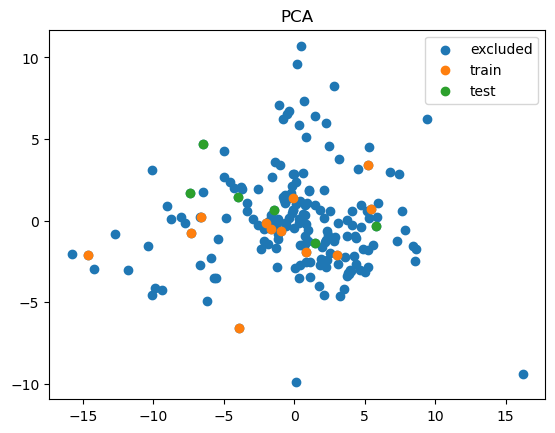

In [29]:
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.scatter(x_pca[data_sub['Ligand#'].isin(x_train['Ligand#']),0],x_pca[data_sub['Ligand#'].isin(x_train['Ligand#']),1])
plt.scatter(x_pca[data_sub['Ligand#'].isin(x_test['Ligand#']),0],x_pca[data_sub['Ligand#'].isin(x_test['Ligand#']),1])
plt.legend(['excluded','train','test'])
plt.title('PCA')

Text(0, 0.5, 'dihedral_angle_1')

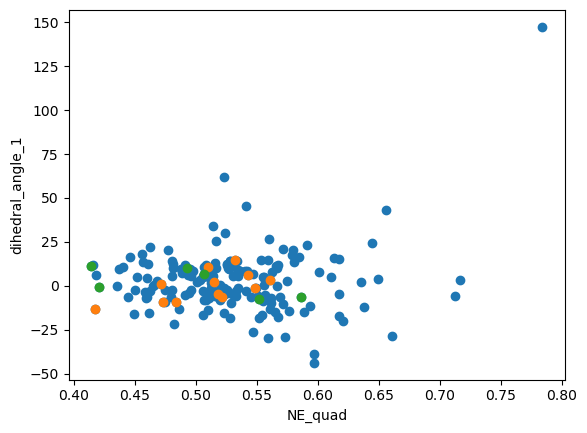

In [30]:
plt.scatter(data_sub['NE_quad'].values,data_sub['dihedral_angle_1'].values)
plt.scatter(data_sub[data_sub['Ligand#'].isin(x_train['Ligand#'])]['NE_quad'].values, data_sub[data_sub['Ligand#'].isin(x_train['Ligand#'])]['dihedral_angle_1'].values)
plt.scatter(data_sub[data_sub['Ligand#'].isin(x_test['Ligand#'])]['NE_quad'].values, data_sub[data_sub['Ligand#'].isin(x_test['Ligand#'])]['dihedral_angle_1'].values)
plt.xlabel('NE_quad')
plt.ylabel('dihedral_angle_1')

In [ ]:
# try regression with loaded representations
selected_ligand_representations = ['dft_nbd_model']
target = 'DDG'
target_threshold = None
rf_model = RandomForestRegressor(random_state=42)
scoring = 'r2'
train_splits = 5
n_jobs = int(n_cpu*0.8)  # using 0.8 of the available CPUs for parallelization
binary = False
plot_dendrograms = False
substrate_names_column = 'Substrate'
ligand_numbers_column = 'Ligand#'
selected_substrate = 'SM1'
training_size = 0.8  # 80% of data for subset substrate is used for training

subset_random_seeds = np.arange(0, 10, 1)  # 10 different random seeds for selecting a random subset of the data
print_ml_results = True
reduce_train_test_data_dimensionality = False
transformer = None
performance_threshold = 0.75  # loop of decreasing subset size and trying random seeds is stopped when performance is above this threshold

print('Training and testing regression')
print(f'Test size: {1/train_splits}')
res = predict_within_substrate_class_for_random_subset(selected_ligand_representations,
                                ligand_numbers_column, substrate_names_column, target, target_threshold, train_splits, binary,
                                selected_substrate, training_size, rf_model, scoring, print_ml_results, n_jobs, subset_random_seeds, performance_threshold, plot_dendrograms, reduce_train_test_data_dimensionality, transformer)

In [ ]:
res.fig_fi

In [ ]:
print(res.testing_performance_test)

In [ ]:



#IMPORT DATA
data = pd.read_excel('/projects/home/cvalsecc/robbert_list/data/C=C_AH_dataset_v3.3.xlsx', 'All data')
data = data[data['Data group'].isin(['Main data set','Additional set'])]
data = data[data['Time [h]']==16]
data = data[data['Solvent']=='Methanol']
data = data[~((data['Starting material']=='SM8')&(data['Temperature [°C]']==25))]
data = data.loc[:,['Starting material','Starting material SMILES','Solvent', 'Ligand#','Product SMILES','Temperature [°C]','Hydrogen [bar]','Time [h]','Conversion [-]','ΔΔG‡ [kJ/mol]']]

#data = data[data['Starting material'].isin(['SM1','SM2','SM3','SM7','SM8'])]

ligand = pd.read_excel('/projects/home/cvalsecc/robbert_list/data/C=C_AH_dataset_v3.3.xlsx', 'Ligands')
ligand['Ligand SMILES'] = ligand['Isomeric SMILES'].fillna(ligand['Canonical SMILES'])
ligand = ligand.loc[:,['Ligand#','Ligand SMILES','InChI key main layer']]
ligand.columns = ['Ligand#','Ligand SMILES','Ligand InChI_main']

data = ligand.merge(data, on = 'Ligand#', how = 'left')


data = data.loc[:,['Ligand#','Starting material','Temperature [°C]','Hydrogen [bar]','Time [h]','Conversion [-]','ΔΔG‡ [kJ/mol]']]

def do_random_grid_extratrees():
    random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 2, stop = 150, num = 4)],
                   'max_depth': [int(x) for x in np.linspace(1, 10, num = 4)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False]}
                   #'class_weight': ['balanced_subsample','balanced'],
                   #'max_features': ['auto', 'sqrt'],}
    return random_grid

def do_random_grid_rf():
    # define parameters for gridsearchcv
    param_grid = {
        'bootstrap': [False],
        'max_depth': [5, 50, 100],
        'max_features': [3, 5],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [5, 10],
        'n_estimators': [5, 50, 100]
    }
    return param_grid

def do_random_grid_pls():
    n_components = [int(x) for x in np.linspace(start = 2, stop = 50, num = 6)]
    random_grid = {'n_components': n_components}
    return random_grid

def do_model(target, xtrain,ytrain, xtest, ytest, model, grid):
    #model = ExtraTreesRegressor(random_state=0)
    if grid:
        cross_val = KFold(n_splits=5)
        mod_random = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = 5, 
                                       cv = cross_val, verbose=0, random_state=64, n_jobs = -1)
        mod_random.fit(xtrain,ytrain)
        base_model = mod_random.best_estimator_
    
    else:
        base_model = model
        base_model.fit(xtrain,ytrain)
    pred = base_model.predict(xtest)
    score_tst = base_model.score(xtest,ytest)
    score_tr = base_model.score(xtrain,ytrain)
    
    return base_model, score_tst, score_tr


AVAILABLE_LIGAND_REPRESENTATION_TYPES = ['dft_nbd_model','dft_nbd_model_with_solvation', 'dl_chylon', 'ecfp', 'sigmangroup']
models = [ExtraTreesRegressor(random_state=42), RandomForestRegressor(random_state=42),LinearRegression()]
grids = [do_random_grid_extratrees(), do_random_grid_rf(), None]
#LIGAND DESCRIPTORS BLOCK
target ='ΔΔG‡ [kJ/mol]'    #'Conversion [-]','|ee| [-]'

myfile = open('obj4_res.txt', 'w')

for lig_descr in AVAILABLE_LIGAND_REPRESENTATION_TYPES:
    print(f'-------{lig_descr}-----------')
    for model, grid in zip(models, grids):
        for sub in ['SM1','SM2','SM3','SM7','SM8']:
            print(f'-------{sub}-----------')
            if lig_descr in lig_descr in AVAILABLE_LIGAND_REPRESENTATION_TYPES[2:]:
                lig_descr_df = pd.read_csv(f'/projects/home/cvalsecc/repo/obelix-ml-pipeline/obelix_ml_pipeline/data/ligand_representations/ligands_{lig_descr}.csv', sep = ',|;', engine = 'python')            

            else:
                lig_descr_df = pd.read_csv(f'/projects/home/cvalsecc/repo/obelix-ml-pipeline/obelix_ml_pipeline/data/ligand_representations/ligands_{lig_descr}.csv', 
                                           sep = ';')
            lig_descr_df = lig_descr_df.dropna(axis = 0)

            data_sub = data[(data['Starting material']==sub)&(data['Ligand#'].isin(lig_descr_df['Ligand#'].values))]
            data_sub = data_sub.drop(['Starting material','Temperature [°C]','Hydrogen [bar]','Time [h]'], axis = 1)
            data_sub = data_sub.merge(lig_descr_df, on='Ligand#')

            np.random.seed(0)
            random_seeds = np.random.randint(1,100000,1000)

            for frac in [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]:
                print(f'---{frac}---------------')
                for seed in random_seeds:
                    X_train, X_excluded = train_test_split(data_sub, test_size=frac, random_state=seed)

                    x_train, x_test, y_train, y_test = train_test_split(X_train.iloc[:,3:].values, X_train[target].values, test_size=0.33, random_state=42)
                    base_model, score_tst, score_tr = do_model(target, x_train,y_train, x_test,y_test, model, grid)

                    if score_tst > 0.65:
                        print(f'descr = {lig_descr}, model = {str(model)}, SM = {sub}, target = {target}, frac = {frac}, seed = {seed}, len_train = {len(y_train)}, len_test = {len(y_test)}, R2 train = {score_tr}, R2 test ={score_tst}')
                        x_train, x_test, y_train, y_test = train_test_split(X_train.iloc[:,3:].values, X_train[target].values, test_size=0.20, random_state=66)
                        base_model, score_tst, score_tr = do_model(target, x_train,y_train, x_test,y_test, model, grid)
                        print('check consistency')
                        print(f'R2 train = {score_tr}, R2 test ={score_tst}')
                        
                        myfile.write("%s\n" % f'descr = {lig_descr}, model = {str(model)}, SM = {sub}, target = {target}, frac = {frac}, seed = {seed}, len_train = {len(y_train)}, len_test = {len(y_test)}, R2 train = {score_tr}, R2 test ={score_tst}')
                        myfile.write("%s\n" % 'check consistency')
                        myfile.write("%s\n" % f'R2 train = {score_tr}, R2 test ={score_tst}')
                        
                        
myfile.close()
text_file.close()